In [1]:
import nltk
import gensim.models.word2vec as w2v

from sklearn.manifold import TSNE

import pandas as pd
import numpy as np

import glob
import re
import multiprocessing

import matplotlib as plt
import seaborn as sns

%matplotlib inline

/Users/attila/miniconda/envs/py3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Prepare Corpus

#### Load the books from the files

In [2]:
# You can find the books here: https://drive.google.com/drive/u/0/folders/0Bx3BucK4gM3Qa05FQWJTQTRSeU0

books_file_name = sorted(glob.glob('data/*.txt'))

In [3]:
print('List of the books:')
books_file_name

List of the books:


['data/Harry Potter 1 - Harry Potter and the Sorcerer s Stone - J  K  Rowling & Mary Grandpre.txt',
 'data/Harry Potter 2 - Harry Potter and the Chamber of Secrets - J  K  Rowling & Mary Grandpre.txt',
 'data/Harry Potter 3 - Harry Potter and the Prisoner of Azkaban - J  K  Rowling & Mary Grandpre.txt',
 'data/Harry Potter 4 - Harry Potter and the Goblet of Fire - J  K  Rowling & Mary Grandpre.txt',
 'data/Harry Potter 5 - Harry Potter and the Order of the Phoenix - J  K  Rowling & Mary Grandpre.txt',
 'data/Harry Potter 6 - Harry Potter and the Half-Blood Prince - J  K  Rowling & Mary Grandpre.txt',
 'data/Harry Potter 7 - Harry Potter and the Deathly Hallows - J  K  Rowling & Mary Grandpre.txt']

#### Combine the books into one string

In [25]:
corpus = ''

for file in books_file_name:
    print('Reading book {0}'.format(file))
    with open(file, 'r') as book:
        corpus += book.read()

print('\nCorpus length is {0} characters long'.format(len(corpus)))

Reading book data/Harry Potter 1 - Harry Potter and the Sorcerer s Stone - J  K  Rowling & Mary Grandpre.txt
Reading book data/Harry Potter 2 - Harry Potter and the Chamber of Secrets - J  K  Rowling & Mary Grandpre.txt
Reading book data/Harry Potter 3 - Harry Potter and the Prisoner of Azkaban - J  K  Rowling & Mary Grandpre.txt
Reading book data/Harry Potter 4 - Harry Potter and the Goblet of Fire - J  K  Rowling & Mary Grandpre.txt
Reading book data/Harry Potter 5 - Harry Potter and the Order of the Phoenix - J  K  Rowling & Mary Grandpre.txt
Reading book data/Harry Potter 6 - Harry Potter and the Half-Blood Prince - J  K  Rowling & Mary Grandpre.txt
Reading book data/Harry Potter 7 - Harry Potter and the Deathly Hallows - J  K  Rowling & Mary Grandpre.txt

Corpus length is 6274463 characters long


#### Split the corpus into the sentences

In [26]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sentences = tokenizer.tokenize(corpus)

In [27]:
def sentence_to_words(sentence):
    # remove non leter characters
    cleaned_sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    
    # convert sentence to words
    words = cleaned_sentence.lower().split()
    
    return words

In [28]:
words_corpus = []

# for now let's leave only words and don't remove stop words
for sentence in sentences:
    if len(sentence) > 0:
        words_corpus.append(sentence_to_words(sentence))

In [29]:
tokens_number = sum([len(sub_corpus) for sub_corpus in words_corpus])
print('The words corpus contains {0:,} tokens'.format(tokens_number))

The words corpus contains 1,123,298 tokens


### Train Word2Vec

In [30]:
# 3 main tasks that vectors help with
# DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors. More dimensions = more generalized.
num_features = 500

# Minimum word count
min_word_count = 35

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window size
context_size = 10

# Downsample setting for frequent words.
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
seed = 42

In [ ]:
%%time

# Initialize and train the model
model = w2v.Word2Vec(
    sentences=words_corpus,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

# If you don't plan to train the model any further, 
# calling init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

In [6]:
model_name = '500features_35minwords_10context'

# save the model for later use.
# model.save('models/' + model_name)

# load pre-saved model
model = w2v.Word2Vec.load('models/' + model_name)

In [7]:
print("Word2Vec vocabulary length:", len(model.vocab))

Word2Vec vocabulary length: 2540


### Compress the word vectors into 2D space and plot them

In [8]:
all_word_vectors_matrix = model.syn0

In [9]:
tsne = TSNE(n_components=2, random_state=42)

In [10]:
%%time

all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

CPU times: user 17.2 s, sys: 1.61 s, total: 18.8 s
Wall time: 17.6 s


#### Plot the big picture

In [11]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[model.vocab[word].index])
            for word in model.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [12]:
points.head()

,word,x,y
0,month,-5.773528,9.341201
1,headed,0.158027,10.922594
2,defensive,-7.002931,5.337798
3,greyback,-2.879063,1.352507
4,memory,-10.490271,-9.141953


In [13]:
sns.set_context('poster')

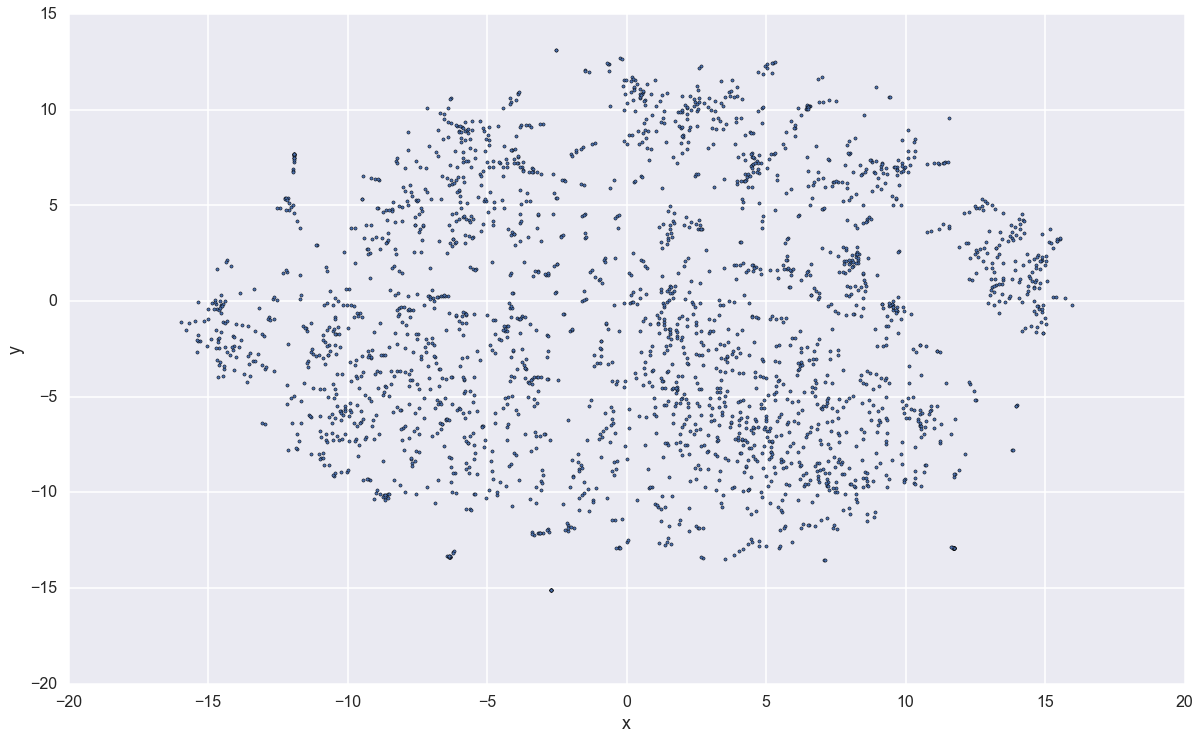

In [14]:
points.plot.scatter('x', 'y', s=10, figsize=(20, 12))

In [15]:
# Zoom in to some interesting places
def plot_by_region(x_range, y_range):
    slice = points[
        (x_range[0] <= points.x) & (points.x <= x_range[1]) & 
        (y_range[0] <= points.y) & (points.y <= y_range[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(15, 12))
    
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

In [16]:
# Find place by keyword
def plot_by_word(word, zoom = 1.5):
    value = points[points.word == word]
    
    if (len(value)):
        x_range = (value.x.values[0] - zoom, value.x.values[0] + zoom)
        y_range = (value.y.values[0] - zoom, value.y.values[0] + zoom)
        
        print('Coordinates: {}'.format((x_range, x_range)))
        
        slice = points[
            (points.x >= x_range[0]) & (points.x <= x_range[1]) & 
            (points.y >= y_range[0]) & (points.y <= y_range[1])
        ]
        
        ax = slice.plot.scatter('x', 'y', s=35, figsize=(15, 12))
        
        for i, point in slice.iterrows():
            font_size = 11
            font_weight = 'normal'
            
            if point.x == value.x.values[0] and point.y == value.y.values[0]:
                font_size = 16
                font_weight = 'bold'
            
            ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=font_size, fontweight=font_weight)
    else:
        print('Not word "{0}" in the model\'s vocabulary.'.format(word))

Coordinates: ((4.2331463571638297, 7.2331463571638297), (4.2331463571638297, 7.2331463571638297))


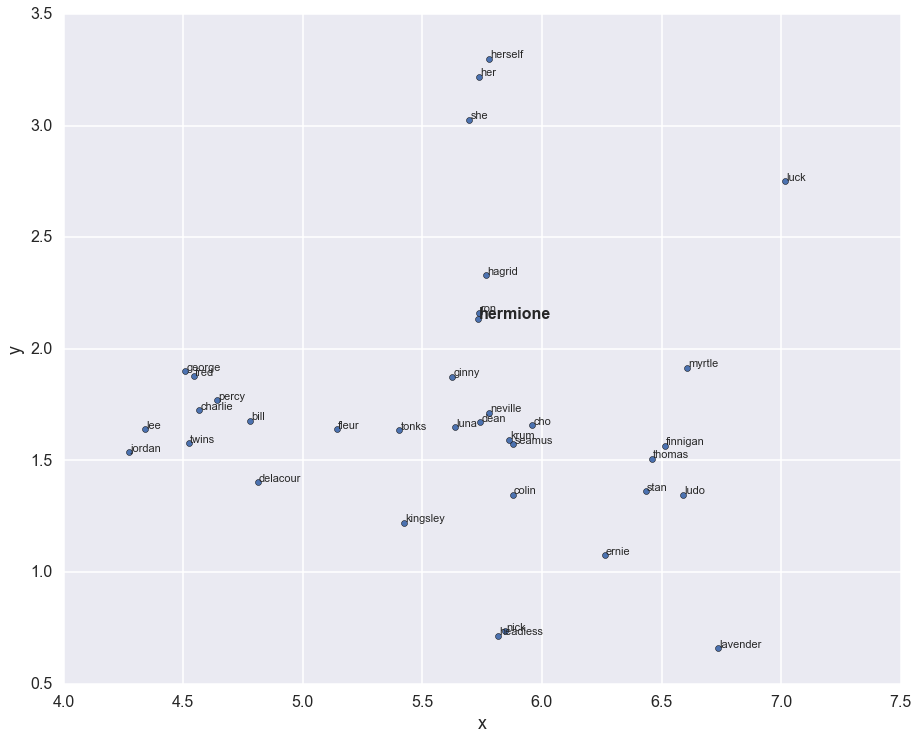

In [17]:
# Positive characters
plot_by_word('hermione')

Coordinates: ((-13.297387299696917, -10.297387299696917), (-13.297387299696917, -10.297387299696917))


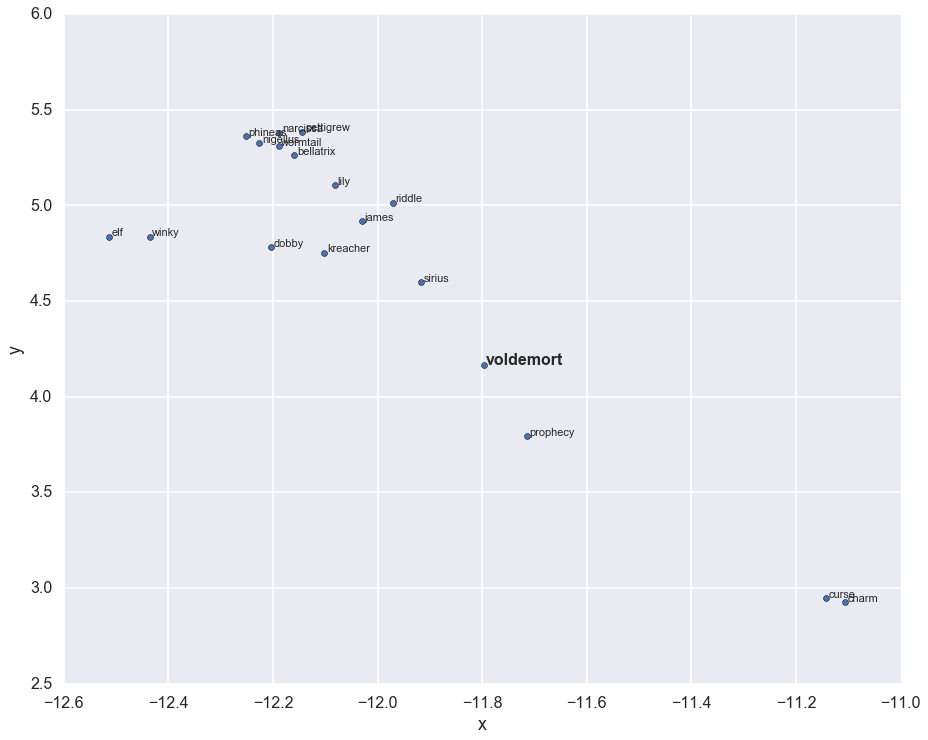

In [18]:
# Mostly negative characters
plot_by_word('voldemort')

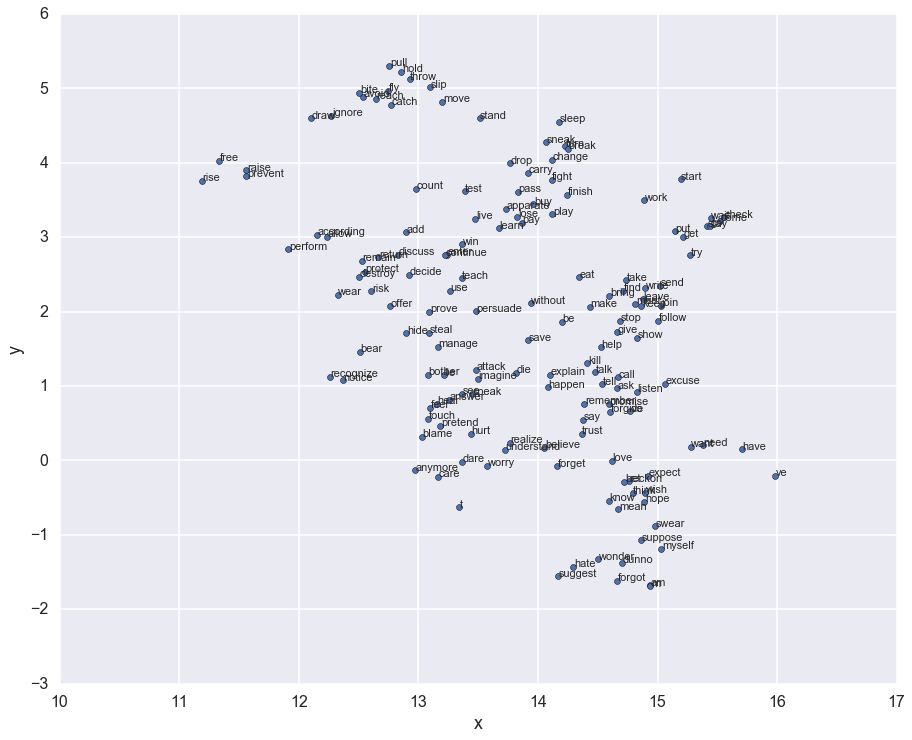

In [21]:
# you can investigate different clusters of the words
plot_by_region(x_range=(11, 16), y_range=(-2, 6))

### Play around with world of the vectors.

#### Find similar things.

In [25]:
# who is related to the villain of the piece?
model.most_similar('voldemort')

[('sirius', 0.7572411298751831),
 ('prophecy', 0.7566839456558228),
 ('regulus', 0.6852266788482666),
 ('riddle', 0.6817686557769775),
 ('dumbledore', 0.679080605506897),
 ('james', 0.6539241075515747),
 ('snape', 0.6473312377929688),
 ('fear', 0.6417621970176697),
 ('curse', 0.6405675411224365),
 ('power', 0.6402340531349182)]

In [26]:
# quite easy to find all Houses of Hogwarts School if you know at least one.
model.most_similar('ravenclaw')

[('slytherin', 0.9244858026504517),
 ('gryffindor', 0.8578783273696899),
 ('hufflepuff', 0.8507870435714722),
 ('seven', 0.8157374858856201),
 ('fourth', 0.8070508241653442),
 ('village', 0.7965232133865356),
 ('six', 0.7946403622627258),
 ('houses', 0.7855971455574036),
 ('eleven', 0.7767012119293213),
 ('fifth', 0.7731844186782837)]

#### Who once here?

In [33]:
# who is good, who is bad?
model.doesnt_match('harry hermione voldemort ron neville'.split())

'voldemort'

In [34]:
# Harry is the main character, so he doesn't related to the common characters.
model.doesnt_match('harry hermione ron'.split())

'harry'

In [68]:
model.doesnt_match('gryffindor hermione ron darco'.split())

'gryffindor'

#### Linear relationships between word pairs.

In [69]:
def nearest_similarity(first_1, first_2, second_1):
    similarities = model.most_similar(
        positive=[first_2, second_1],
        negative=[first_1]
    )
    second_2 = similarities[0][0]
    
    print('{first_1} is related to {first_2}, as {second_1} is related to {second_2}'.format(**locals()))

In [70]:
nearest_similarity('harry', 'gryffindor', 'slytherin')

harry is related to gryffindor, as slytherin is related to points


In [71]:
nearest_similarity('ron', 'gryffindor', 'cho')

ron is related to gryffindor, as cho is related to ravenclaw
